In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import date

In [2]:
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scikit_posthocs as sp

In [3]:
import warnings; warnings.simplefilter('ignore')

In [4]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [5]:
#random low-pmi condition missing
categories_perturb = ['original', 'nouns', 'nouns-del50%', 'random-nouns', 'nounsverbs', 'nounsverbsadj', 'contentwords', 'functionwords', 'passageshuffle','random-sent']
categories_scrambled = ['original', 'scrambled1', 'scrambled3', 'scrambled5', 'scrambled7', 'lowpmi', 'backward', 'random-wl']#, random-lowpmi]

categories = [categories_perturb, categories_scrambled]
keys = ["perturb", "scrambled"]

categories_dict = dict(zip(keys, categories))

In [6]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "model=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #print(layer_list)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['gpt2','distilgpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            if model_identifier == 'xlnet-large-cased':
                double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            if model_identifier == 'bert-large-uncased-whole-word-masking':
                double_digits = [elm for elm in layer_list if '.layer.' in elm and len(elm.split('.layer.')[-1].split('.')[0]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            return layers
            break

In [7]:
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
    return max_score, error

In [8]:
def get_best_scores_df(model_identifier,categories_dict,scr_perturb=None):
    """
    input: model_identifier
    output: dictionary containing the last score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    max_scores = []
    errors = []
    raw_scores = []
    subject_scores = []
    
    subdict = {}
    
    layers = get_all_layers(model_identifier)
    #print(layers)
    
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            if (f"-encoding-{scr_perturb}" in filename) or ("-encoding-scrambled-original" in filename):
                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                
                if scr_perturb == "perturb":
                    condition = re.sub("perturb-","",condition)
                    condition = re.sub("scrambled-","",condition)
                    if condition == "randomsentenceshuffle":
                        condition = "random-sent"
                    if condition == "nouns-delete50percent":
                        condition = "nouns-del50%"
                    
                elif scr_perturb == "scrambled":
                    if not any(x in condition for x in ["1", "3", "5", "7"]):
                        condition = re.sub("scrambled-","",condition)
                    else:
                        condition = condition
                #print(condition)
                
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result_all = out['data']
                result = out['data'].values

                # Package for stats
                final_layer = layers[-1]
                #print(final_layer)

                raw_score = result_all.raw.raw
                final_layer_raw = raw_score[{"layer": [layer == final_layer for layer in raw_score["layer"]]}]
    #           raw_scores.append(final_layer_raw) # if saving all
                final_layer_raw = final_layer_raw.fillna(0)
                raw_scores.append(final_layer_raw.values)

                subject_score = final_layer_raw.groupby('subject').median().values
                subject_scores.append(subject_score)

                # append to dict
                subdict[condition] = subject_score

                #print(result, '\n\n')
                max_score, error = get_max_score(result)

                conditions.append(condition)
                max_scores.append(max_score)
                errors.append(error)
            
    index = conditions
    df = pd.DataFrame({'score': max_scores,
    'error': errors, 'condition':conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=categories_dict[scr_perturb])
    scores_df = df.sort_values(by='condition')
    
    # Currently not outputted
    df_stats = pd.DataFrame({'score': raw_scores}, index=conditions)
    df_substats = pd.DataFrame({'score': subject_scores}, index=conditions)
    
    # Transform subdict to statsmodel api form:
    x = subdict.copy()
    subdf = pd.DataFrame(x)
    subdf = subdf.melt(var_name='groups', value_name='values')
    
    subdf['groups'] = pd.Categorical(subdf['groups'], categories=categories_dict[scr_perturb], ordered=True)
    subdf = subdf.sort_values('groups')
    
    return scores_df, subdict, subdf

In [9]:
def anova_ttest(model_identifier,categories_dict,scr_perturb=None):
    
    scores, subdict, subdf = get_best_scores_df(model_identifier,categories_dict,scr_perturb=scr_perturb)
    
    #curr_categories = categories_dict[scr_perturb]
    
    if scr_perturb == "scrambled":
        F, p = stats.f_oneway(subdict['original'], subdict['scrambled1'],
                         subdict['scrambled3'], subdict['scrambled5'],
                         subdict['scrambled7'], subdict['lowpmi'],
                         subdict['random-wl'])
    elif scr_perturb == "perturb":
        F, p = stats.f_oneway(subdict['original'], subdict['nouns'],
                     subdict['nouns-del50%'], subdict['random-nouns'],
                     subdict['nounsverbs'], subdict['nounsverbsadj'],
                     subdict['contentwords'], subdict['functionwords'],
                     subdict['passageshuffle'], subdict['random-sent'])
    
    print(f'ANOVA F-statistic and p-value: {F,p}')
    
    ttest = sp.posthoc_ttest(subdf, val_col='values', group_col='groups')#, p_adjust='fdr_bh')
    plt.figure(figsize=(7,7))
    sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
    
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"
    plt.title('{}'.format(model_identifier),fontsize=18)
    plt.subplots_adjust(top=0.8) 
    
    if not os.path.isdir("fig"):
        os.mkdir("fig")
    savename = f'fig/{date.today()}_stats-match-to-brain_{scr_perturb}_{model_identifier}.png'
    plt.savefig(savename, bbox_inches='tight', dpi=240)
    plt.show()

    return ttest

In [10]:
# Plot arguments
#args = {'annot':ttest}
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.55, 0.04, 0.3]}

Loading lookup from /om2/user/ckauf/anaconda/envs/perturbedenv/lib/python3.6/site-packages/brainio_collection/lookup.csv
ANOVA F-statistic and p-value: (5.5992268233665605, 0.00010509641435861499)
            original  scrambled1  scrambled3  scrambled5  scrambled7  lowpmi  \
original        -1.0         0.0         0.0         0.0         0.0     0.0   
scrambled1       0.0        -1.0         0.0         0.0         0.0     0.0   
scrambled3       0.0         0.0        -1.0         0.0         0.0     0.0   
scrambled5       0.0         0.0         0.0        -1.0         0.0     0.0   
scrambled7       0.0         0.0         0.0         0.0        -1.0     0.0   
lowpmi           0.0         0.0         0.0         0.0         0.0    -1.0   
backward         0.0         3.0         3.0         2.0         0.0     0.0   
random-wl        2.0         1.0         1.0         1.0         2.0     2.0   

            backward  random-wl  
original         0.0        2.0  
scrambled1    

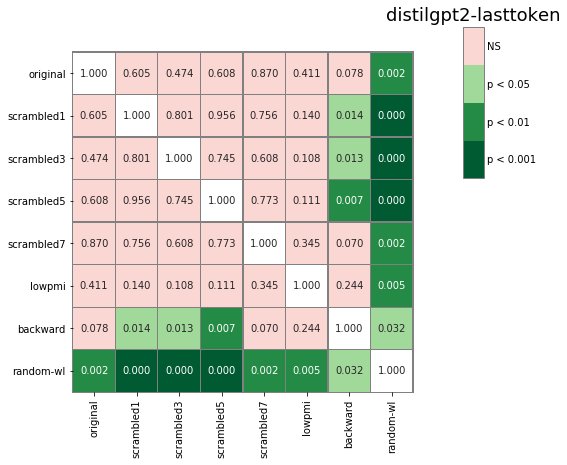

In [11]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="scrambled")

ANOVA F-statistic and p-value: (4.922024757453368, 0.000348079751746014)
            original  scrambled1  scrambled3  scrambled5  scrambled7  lowpmi  \
original        -1.0         0.0         0.0         0.0         0.0     0.0   
scrambled1       0.0        -1.0         0.0         0.0         0.0     0.0   
scrambled3       0.0         0.0        -1.0         0.0         0.0     0.0   
scrambled5       0.0         0.0         0.0        -1.0         0.0     0.0   
scrambled7       0.0         0.0         0.0         0.0        -1.0     0.0   
lowpmi           0.0         0.0         0.0         0.0         0.0    -1.0   
backward         0.0         0.0         0.0         0.0         0.0     0.0   
random-wl        3.0         2.0         2.0         1.0         2.0     1.0   

            backward  random-wl  
original         0.0        3.0  
scrambled1       0.0        2.0  
scrambled3       0.0        2.0  
scrambled5       0.0        1.0  
scrambled7       0.0        2.0  
lo

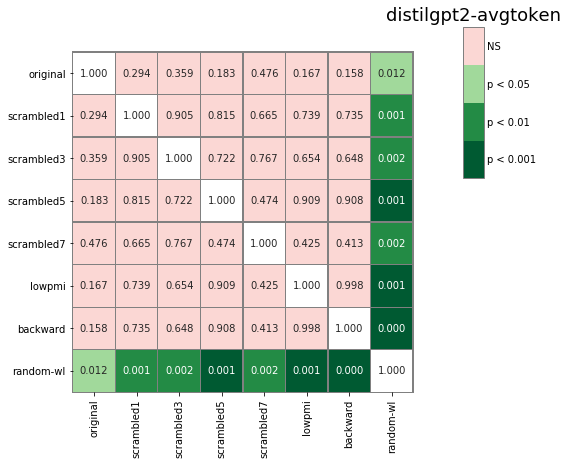

In [12]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="scrambled")

ANOVA F-statistic and p-value: (10.633751491221389, 4.5952334924453566e-11)
                original  nouns  nouns-del50%  random-nouns  nounsverbs  \
original            -1.0    0.0           1.0           3.0         0.0   
nouns                0.0   -1.0           1.0           0.0         0.0   
nouns-del50%         1.0    1.0          -1.0           0.0         1.0   
random-nouns         3.0    0.0           0.0          -1.0         0.0   
nounsverbs           0.0    0.0           1.0           0.0        -1.0   
nounsverbsadj        0.0    0.0           1.0           0.0         0.0   
contentwords         0.0    0.0           1.0           0.0         0.0   
functionwords        1.0    1.0           0.0           2.0         1.0   
passageshuffle       0.0    0.0           1.0           0.0         0.0   
random-sent          2.0    0.0           3.0           0.0         3.0   

                nounsverbsadj  contentwords  functionwords  passageshuffle  \
original            

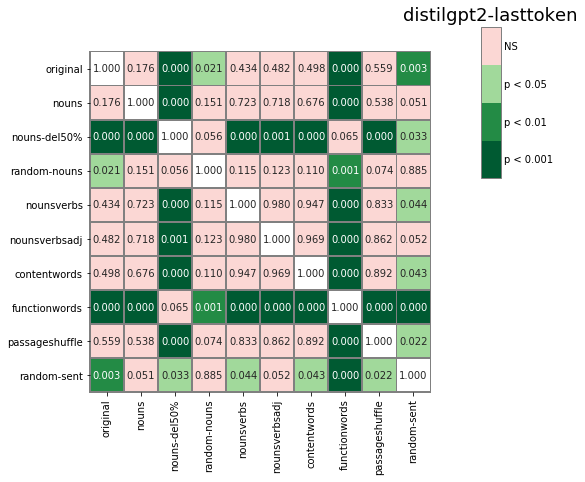

In [13]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="perturb")

ANOVA F-statistic and p-value: (25.69003638474271, 2.773498154312132e-21)
                original  nouns  nouns-del50%  random-nouns  nounsverbs  \
original            -1.0    0.0           1.0           3.0         0.0   
nouns                0.0   -1.0           1.0           3.0         0.0   
nouns-del50%         1.0    1.0          -1.0           2.0         1.0   
random-nouns         3.0    3.0           2.0          -1.0         2.0   
nounsverbs           0.0    0.0           1.0           2.0        -1.0   
nounsverbsadj        0.0    0.0           1.0           3.0         0.0   
contentwords         0.0    0.0           1.0           2.0         0.0   
functionwords        1.0    1.0           0.0           1.0         1.0   
passageshuffle       0.0    0.0           1.0           0.0         3.0   
random-sent          1.0    1.0           2.0           0.0         1.0   

                nounsverbsadj  contentwords  functionwords  passageshuffle  \
original              

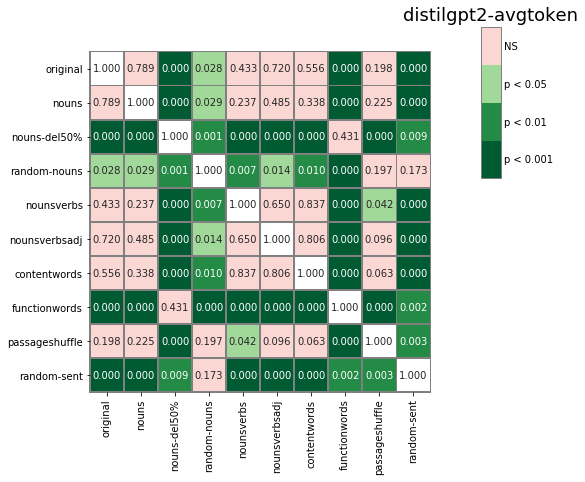

In [14]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="perturb")

ANOVA F-statistic and p-value: (19.96864256448304, 5.546019255346611e-18)
                original  nouns  nouns-del50%  random-nouns  nounsverbs  \
original            -1.0    0.0           1.0           1.0         0.0   
nouns                0.0   -1.0           1.0           1.0         0.0   
nouns-del50%         1.0    1.0          -1.0           0.0         1.0   
random-nouns         1.0    1.0           0.0          -1.0         1.0   
nounsverbs           0.0    0.0           1.0           1.0        -1.0   
nounsverbsadj        0.0    0.0           1.0           1.0         0.0   
contentwords         0.0    0.0           1.0           1.0         0.0   
functionwords        1.0    1.0           3.0           0.0         1.0   
passageshuffle       0.0    0.0           2.0           2.0         3.0   
random-sent          1.0    1.0           2.0           3.0         1.0   

                nounsverbsadj  contentwords  functionwords  passageshuffle  \
original              

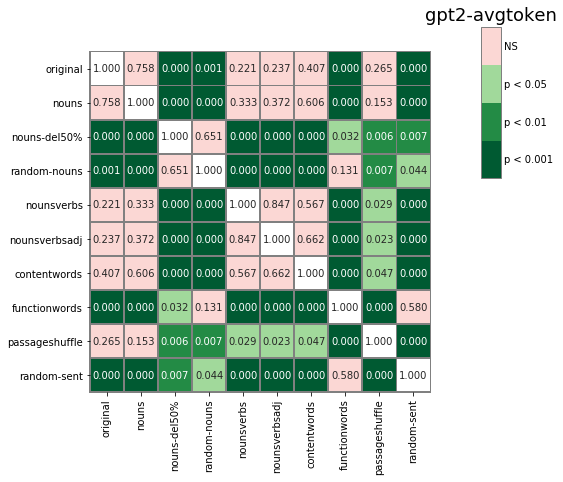

In [15]:
g=anova_ttest('gpt2-avgtoken',categories_dict,scr_perturb="perturb")

ANOVA F-statistic and p-value: (16.06003803850984, 2.293674919776855e-15)
                original  nouns  nouns-del50%  random-nouns  nounsverbs  \
original            -1.0    2.0           1.0           1.0         0.0   
nouns                2.0   -1.0           3.0           0.0         0.0   
nouns-del50%         1.0    3.0          -1.0           0.0         2.0   
random-nouns         1.0    0.0           0.0          -1.0         3.0   
nounsverbs           0.0    0.0           2.0           3.0        -1.0   
nounsverbsadj        0.0    0.0           1.0           2.0         0.0   
contentwords         0.0    0.0           1.0           2.0         0.0   
functionwords        1.0    1.0           2.0           2.0         1.0   
passageshuffle       2.0    0.0           2.0           0.0         0.0   
random-sent          1.0    3.0           0.0           0.0         1.0   

                nounsverbsadj  contentwords  functionwords  passageshuffle  \
original              

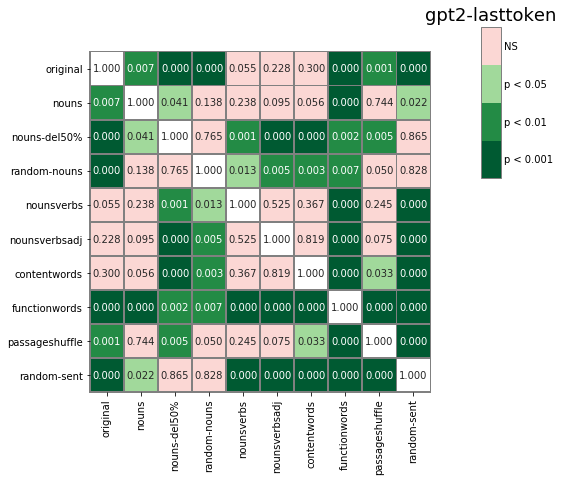

In [16]:
g=anova_ttest('gpt2',categories_dict,scr_perturb="perturb")

ANOVA F-statistic and p-value: (5.782903123669124, 7.638305451258632e-05)
            original  scrambled1  scrambled3  scrambled5  scrambled7  lowpmi  \
original        -1.0         0.0         0.0         0.0         0.0     0.0   
scrambled1       0.0        -1.0         0.0         0.0         0.0     0.0   
scrambled3       0.0         0.0        -1.0         0.0         0.0     0.0   
scrambled5       0.0         0.0         0.0        -1.0         0.0     0.0   
scrambled7       0.0         0.0         0.0         0.0        -1.0     0.0   
lowpmi           0.0         0.0         0.0         0.0         0.0    -1.0   
backward         0.0         0.0         0.0         0.0         0.0     0.0   
random-wl        1.0         1.0         1.0         1.0         1.0     1.0   

            backward  random-wl  
original         0.0        1.0  
scrambled1       0.0        1.0  
scrambled3       0.0        1.0  
scrambled5       0.0        1.0  
scrambled7       0.0        1.0  
l

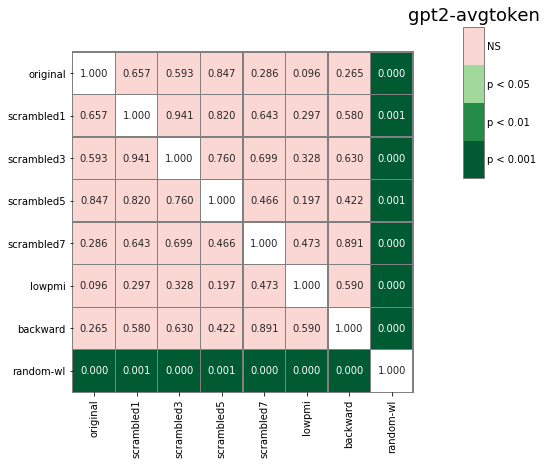

In [17]:
g=anova_ttest('gpt2-avgtoken',categories_dict,scr_perturb="scrambled")

ANOVA F-statistic and p-value: (6.912040296599916, 1.1339711847164989e-05)
            original  scrambled1  scrambled3  scrambled5  scrambled7  lowpmi  \
original        -1.0         0.0         0.0         0.0         0.0     0.0   
scrambled1       0.0        -1.0         0.0         0.0         0.0     0.0   
scrambled3       0.0         0.0        -1.0         0.0         0.0     0.0   
scrambled5       0.0         0.0         0.0        -1.0         0.0     0.0   
scrambled7       0.0         0.0         0.0         0.0        -1.0     0.0   
lowpmi           0.0         0.0         0.0         0.0         0.0    -1.0   
backward         0.0         0.0         0.0         0.0         0.0     0.0   
random-wl        1.0         1.0         1.0         1.0         1.0     1.0   

            backward  random-wl  
original         0.0        1.0  
scrambled1       0.0        1.0  
scrambled3       0.0        1.0  
scrambled5       0.0        1.0  
scrambled7       0.0        1.0  


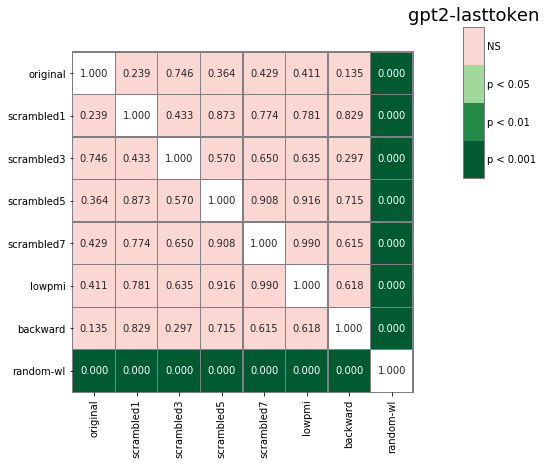

In [18]:
g=anova_ttest('gpt2',categories_dict,scr_perturb="scrambled")

# Loop into subplots

In [19]:
import math
from matplotlib.gridspec import GridSpec

def get_stats_loop(model_list,scr_perturb=None):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    
    fig2 = plt.figure(constrained_layout=True, figsize=(12, 5.5*nrows))
    fig2.suptitle(f'Post-hoc ANOVA pairwise t-tests | {scr_perturb}', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                scores, subdict, subdf = get_best_scores_df(model_list[model_counter],categories_dict,scr_perturb=scr_perturb)
    
                if scr_perturb == "scrambled":
                    F, p = stats.f_oneway(subdict['original'], subdict['scrambled1'],
                                     subdict['scrambled3'], subdict['scrambled5'],
                                     subdict['scrambled7'], subdict['lowpmi'],
                                     subdict['random-wl'])
                elif scr_perturb == "perturb": #take out when last model's run through
                    F, p = stats.f_oneway(subdict['original'], subdict['nouns'],
                                 subdict['nouns-del50%'], subdict['random-nouns'],
                                 subdict['nounsverbs'], subdict['nounsverbsadj'],
                                 subdict['contentwords'], subdict['functionwords'],
                                 subdict['passageshuffle'], subdict['random-sent'])
    
                ttest = sp.posthoc_ttest(subdf, val_col='values', group_col='groups')#, p_adjust='fdr_bh')
                #f2_ax[-1].figure(figsize=(6,6))
                sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
                f2_ax[-1].set_title(f'{model_list[model_counter]}',fontsize=18, pad=15)
                model_counter += 1
    fig2.savefig(f'fig/{date.today()}_stats-match-to-brain_loop_{scr_perturb}.png', bbox_inches='tight')

                original  nouns  nouns-del50%  random-nouns  nounsverbs  \
original            -1.0    0.0           1.0           3.0         0.0   
nouns                0.0   -1.0           1.0           0.0         0.0   
nouns-del50%         1.0    1.0          -1.0           0.0         1.0   
random-nouns         3.0    0.0           0.0          -1.0         0.0   
nounsverbs           0.0    0.0           1.0           0.0        -1.0   
nounsverbsadj        0.0    0.0           1.0           0.0         0.0   
contentwords         0.0    0.0           1.0           0.0         0.0   
functionwords        1.0    1.0           0.0           2.0         1.0   
passageshuffle       0.0    0.0           1.0           0.0         0.0   
random-sent          2.0    0.0           3.0           0.0         3.0   

                nounsverbsadj  contentwords  functionwords  passageshuffle  \
original                  0.0           0.0            1.0             0.0   
nouns             

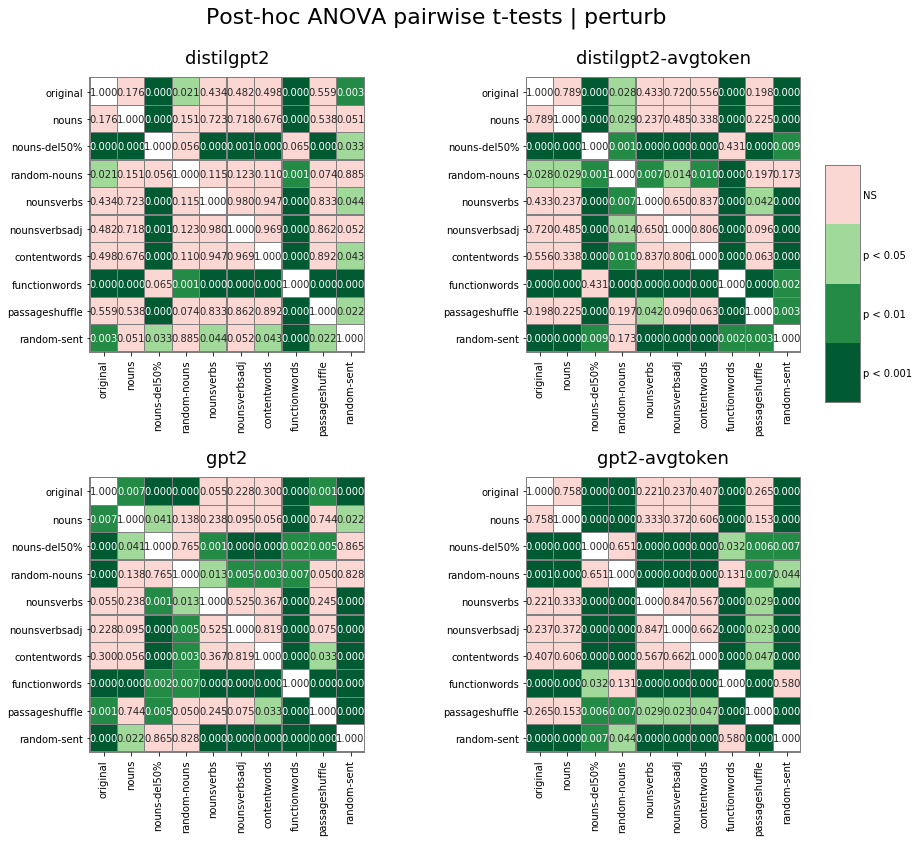

In [20]:
get_stats_loop(["distilgpt2", "distilgpt2-avgtoken", "gpt2", "gpt2-avgtoken"], scr_perturb="perturb")

            original  scrambled1  scrambled3  scrambled5  scrambled7  lowpmi  \
original        -1.0         0.0         0.0         0.0         0.0     0.0   
scrambled1       0.0        -1.0         0.0         0.0         0.0     0.0   
scrambled3       0.0         0.0        -1.0         0.0         0.0     0.0   
scrambled5       0.0         0.0         0.0        -1.0         0.0     0.0   
scrambled7       0.0         0.0         0.0         0.0        -1.0     0.0   
lowpmi           0.0         0.0         0.0         0.0         0.0    -1.0   
backward         0.0         3.0         3.0         2.0         0.0     0.0   
random-wl        2.0         1.0         1.0         1.0         2.0     2.0   

            backward  random-wl  
original         0.0        2.0  
scrambled1       3.0        1.0  
scrambled3       3.0        1.0  
scrambled5       2.0        1.0  
scrambled7       0.0        2.0  
lowpmi           0.0        2.0  
backward        -1.0        3.0  
random-

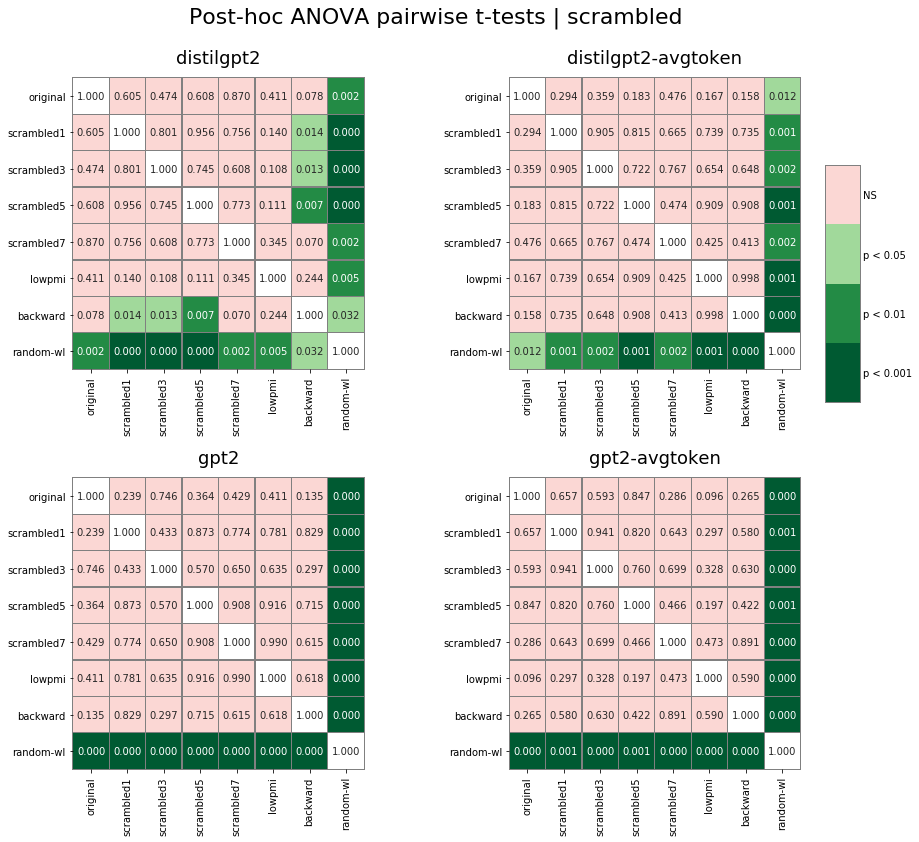

In [21]:
get_stats_loop(["distilgpt2", "distilgpt2-avgtoken", "gpt2", "gpt2-avgtoken"], scr_perturb="scrambled")